# STAT 201 Group 3 Final Report

# Public Art in Vancouver

## Introduction 🏙🌆🌉🌃

Vancouver is home to diverse cultural displays. Yet despite the potential benefits that community arts initiatives may bring, public art and artists as a group of people are thought to be associated with the gentrification of neighborhoods like the Downtown Eastside [(Szőke, T., &amp; Parizeau, K., 2018)](https://www.tandfonline.com/action/doSearch?AllField=%22public+art%22+and+%22community+development%22&SeriesKey=rgeo20). Since Vancouver is notorious for being the site of gentrification across many of its neighborhoods, it could be beneficial to understand the changing development of Vancouver’s communities through the lens of public art and how it develops over time. As such, for this project, our operational definition for gentrification will be the incidence of public art projects in the city of Vancouver to ultimately see if the development of public art, and thus community development, occurred simultaneously, or occurred in different neighborhoods at different times.

In this project, we will try to answer the following question: 

> Is the (mean) installation year of the public art in Downtown similar to Mount Pleasant?

The dataset we plan to work on is named 'Public Art' and is sourced from the City of Vancouver's [Open Data Portal](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj69K7_zZr7AhWzAjQIHdxLDqYQFnoECBoQAw&url=https%3A%2F%2Fwww.destinationvancouver.com%2Factivities%2Fsightseeing%2Fpublic-art-mini-guide%2F&usg=AOvVaw1C7YOKtvv8kVHkkdl_XYie). The dataset contains information on the location, artist, and installation date of documented public art in Vancouver, ranging from the early 1900s to 2022. We're interpreting the data we have as sample data and consider our population ALL public art in Vancouver - whether or not it is publically funded or not is irrelevant. Our population parameter is the **difference in means** because we believe it to be a suitable measure of when public art generally started to develop in each neighborhood. In the future, we may explore hypothesis testing with the medians.

## Preliminary Data Exploration

In [57]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(broom)
library(grid)
library(gridExtra)

### Reading the file from the web

In [58]:
# Code to download file from: https://datasciencebook.ca/reading.html
url <- "https://opendata.vancouver.ca/explore/dataset/public-art/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B"
art_data <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 659 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (16): ArtistProjectStatement, Type, Status, SiteName, SiteAddress, Prima...
dbl  (2): RegistryID, YearOfInstallation

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and wrangling the dataset

We `select` and `filter` for only the relevant data.

In [59]:
art_data <- art_data %>%
    select(Neighbourhood, YearOfInstallation) %>%
    filter(!is.na(Neighbourhood) & !is.na(YearOfInstallation))

head(art_data)

Neighbourhood,YearOfInstallation
<chr>,<dbl>
West End,1977
West End,1967
West End,1965
Mount Pleasant,1948
Grandview-Woodland,1959
Downtown,1966


Since our hypothesis only concerns Downtown and Mount Pleasant, we filter `art_data` into `art_data_required` according to the `Neighbourhood` variable. We then separate our data into two dataframes, one for each neighbourhood.

In [60]:
art_data_required <- art_data %>%
    filter(Neighbourhood == "Downtown" | Neighbourhood == "Mount Pleasant")

downtown = art_data_required %>% filter(Neighbourhood == "Downtown")
mt_pleasant = art_data_required %>% filter(Neighbourhood == "Mount Pleasant")

head(art_data_required)

Neighbourhood,YearOfInstallation
<chr>,<dbl>
Mount Pleasant,1948
Downtown,1966
Downtown,1967
Downtown,1966
Downtown,1910
Downtown,1969


In [74]:
art_data_stats <- art_data_required %>%
    group_by(Neighbourhood) %>%
    summarise(mean = mean(YearOfInstallation), 
              median = median(YearOfInstallation), 
              sd = sd(YearOfInstallation),
              var = var(YearOfInstallation),
              n = n())

### Extracting the summary statistics for future use. Code from:
#   https://stackoverflow.com/questions/7448881/how-to-access-single-elements-in-a-table-in-r
mean_dt <- as.numeric(art_data_stats[1, "mean"])
mean_mp <- as.numeric(art_data_stats[2, "mean"])
var_dt <- as.numeric(art_data_stats[1, "var"])
var_mp <- as.numeric(art_data_stats[2, "var"])
n_dt <- as.numeric(art_data_stats[1, "n"])
n_mp <- as.numeric(art_data_stats[2, "n"])
obs_mean_year_diff <- mean_dt - mean_mp

head(art_data_stats)

Neighbourhood,mean,median,sd,var,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Downtown,2000.572,2008,22.12230,489.3960,201
Mount Pleasant,2008.929,2016,17.37067,301.7403,56


<span style="color:gray">Table 1: Summary statistics of the mean installation year for the neighbourhoods</span>

### Data visualization

Now we plot the sample distribution in histograms and a boxplot for both categories.

As can be seen from the histograms, both groups' distributions are not normal but rather left-skewed, with most installations occurring in the 2010s, and both are unimodal, with peaks again in the 2010s. In the boxplots, Mount Pleasant's median year is greater than Downtown's, and Downtown's inter-quartile range (the middle 50% of years) (1999 to 2016) is wider than Mount Pleasant's (2010 to 2016), meaning that the Downtown sample has a greater spread. The boxplots also display a non-normal distribution due to the uneven quartiles. (This is where the CLT comes into play.)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



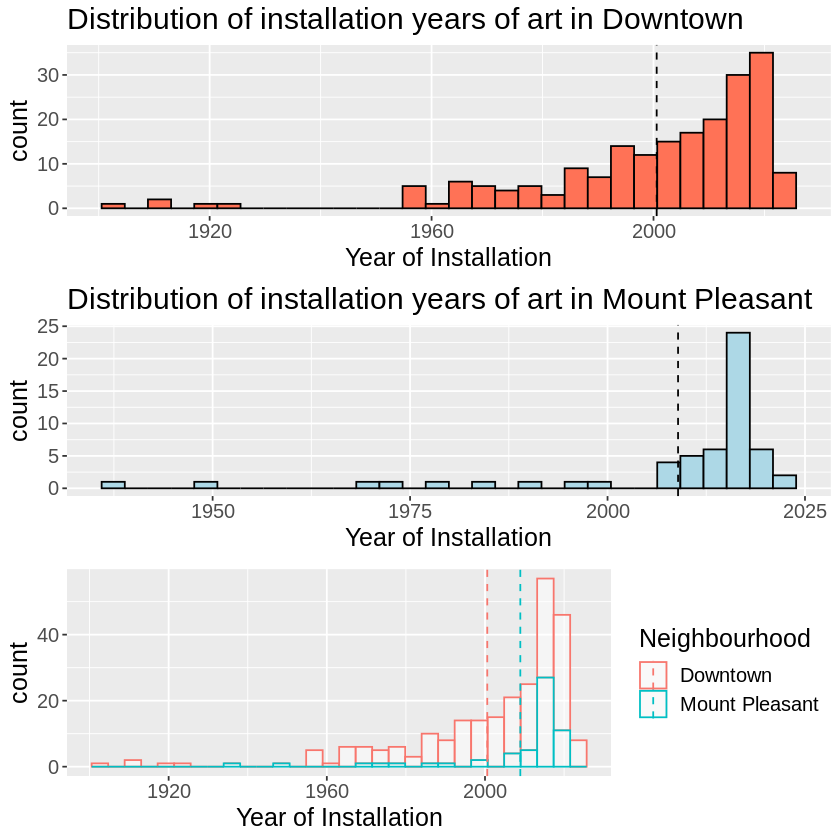

In [62]:
### Code to arrange the plots: Worksheet 8, 3.1
### Code for overlaid histograms:
#   http://www.sthda.com/english/wiki/ggplot2-histogram-plot-quick-start-guide-r-software-and-data-visualization

plots <- list()

# Downtown
plots[[1]] <- downtown %>%
    ggplot() +
    geom_histogram(aes(x = YearOfInstallation), color = "black", fill = "coral1") +
    ggtitle("Distribution of installation years of art in Downtown") +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(aes(xintercept = downtown_mean), linetype = "dashed")

# Mount Pleasant
plots[[2]] <- mt_pleasant %>%
    ggplot() +
    geom_histogram(aes(x = YearOfInstallation), color = "black", fill = "lightblue") +
    ggtitle("Distribution of installation years of art in Mount Pleasant") +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(aes(xintercept = pleasant_mean), linetype = "dashed")

# Overlaid histograms
plots[[3]] <- art_data_required %>%
    ggplot(aes(x = YearOfInstallation, color = Neighbourhood)) +
    geom_histogram(fill="white", alpha = 0.5) +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(data = art_data_stats, aes(xintercept = mean, color = Neighbourhood),
             linetype = "dashed")

grid.arrange(grobs = plots, ncol = 1)

<span style="color:gray">Figure 1: Histograms of installation years in Downtown & Mount Pleasant</span>

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


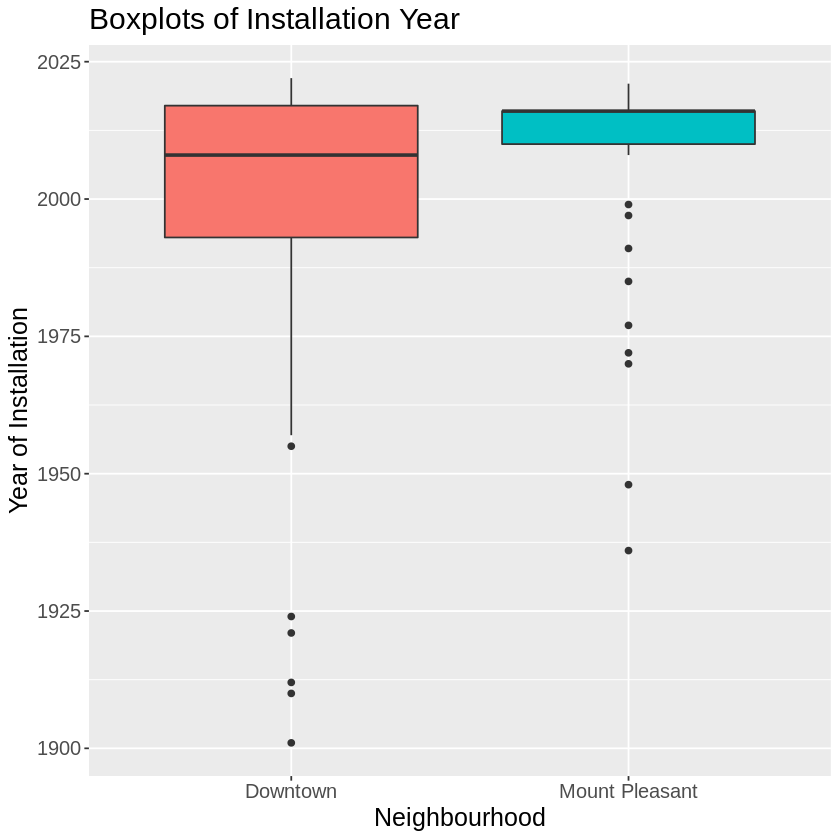

In [63]:
inst_year_boxplots <- art_data_required %>%
    ggplot() +
    geom_boxplot(aes(Neighbourhood, YearOfInstallation, fill = Neighbourhood)) +
    theme(text = element_text(size = 15)) +
    ggtitle("Boxplots of Installation Year") + 
    xlab("Neighbourhood") + 
    ylab("Year of Installation") + 
    guides(fill = FALSE)

inst_year_boxplots

<span style="color:gray">Figure 2: Boxplots of installation years in Downtown & Mount Pleasant</span>

## Methods and Results

Succeeding the preliminary data exploration, our next steps are to test the null hypothesis and construct confidence intervals using bootstrapping and asymptotic methods.

**Let $\mu_1$ be the mean installation year in Downtown and $\mu_2$ be the mean installation year in Mount Pleasant. Our hypotheses are $H_0: \mu_1-\mu_2 = 0$ vs $H_1: \mu_1-\mu_2 \neq 0$. We set our significance level $\alpha$ to 0.10 because we don't think the stakes are high enough that false evidence would have consequences.** 

Methods (subsections):

1. Hypothesis testing and 90% confidence interval via **`infer`**
2. 90% confidence interval via **bootstrapping**
3. Hypothesis testing and 90%, 95% confidence intervals via **CLT**

In the end, we'll compare and comment on the results attained from bootstrapping and the theory-based CLT method.

### Using `infer`

**Null Distribution**

We generate the null model from our sample, a model which assumes that our null hypothesis, $H_0: \mu_1-\mu_2 = 0$, is true.

In [64]:
set.seed(101)

pop_null_distribution <- art_data_required %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(pop_null_distribution)

replicate,stat
<int>,<dbl>
1,5.5484186
2,-0.5249645
3,5.2287669
4,-0.5477967
5,1.1417910
6,-1.4382552


<span style="color:gray">Table 2: Generated differences in means in a world where the null hypothesis is true</span>

**Observed Difference in Means**

We already computed the observed statistic in Table 1: according to our sample, the difference in the mean year of installation of art in `Downtown` and the mean year of installation of art in `Mount Pleasant` is denoted by `pop_obs_diff_means` and equals ~8.36 years. This suggests the mean year of public art installation in Downtown is ~8 years earlier than in Mount Pleasant. But we cannot reject our null hypothesis based solely on this information as we have to account for our sample not being entirely representative of the population, so we continue.

In [65]:
obs_mean_year_diff

[1] -8.356432

**Confidence Interval**

To account for the random variation in samples, we generate a 90% confidence interval for the null model. 90% of the simulated mean difference in years are captured by the interval [-5.411, 5.481] years, assuming $\mu_1-\mu_2 = 0$. (Even though our observed difference in means isn't within this interval, this could've just been a result of sampling variation and thus we wouldn't be able to reject the null hypothesis before further investigation of statistical significance.)

In [66]:
pop_alpha <- pop_null_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

pop_alpha

lower_ci,upper_ci
<dbl>,<dbl>
-5.41107,5.481063


**Visualization**

Let's compare our null model to our test statistic to see if our observed difference in means is statistically significant, i.e. whether the probability of achieving our test statistic is more extreme than our significance level. 

Below is a histogram visualizing the null distribution - the 90% confidence interval is <span style="color:green"> shaded green</span>, the interval covered by the p-value is <span style="color: red"> shaded red</span>, and the observed difference in means is a <span style="color:red"> red line</span>. The pink region is evidently more "extreme" than green region, reflecting the fact that `p-value` $= 0.008$ <<< $\alpha = 0.10$, therefore we can safely reject our null hypothesis.

In [67]:
pop_p_value <- pop_null_distribution %>% 
    get_p_value(obs_stat = pop_obs_diff_means, direction = "both") %>%
    as.numeric()

pop_p_value

[1] 0.008

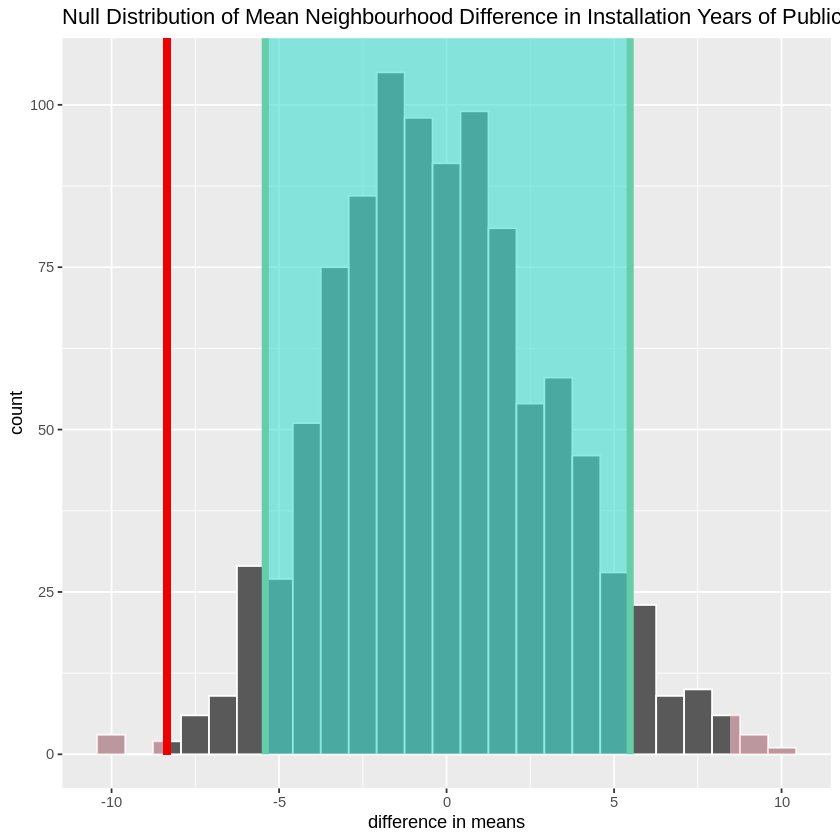

In [68]:
visualize(pop_null_distribution, bins = 25) + 
    shade_p_value(obs_stat = pop_obs_diff_means, direction = "both") +
    shade_confidence_interval(endpoints = pop_alpha) +
    ggtitle("Null Distribution of Mean Neighbourhood Difference in Installation Years of Public Art") +
    xlab("difference in means")

<span style="color:gray">Figure 3: Histogram of difference in means of installation years in Downtown & Mount Pleasant</span>

### Using bootstrapping

**Confidence Interval**

We now generate a bootstrap sampling distribution to produce another 90% confidence interval, which turns out to be [-12.69, -3.59] years.

In [69]:
set.seed(101)

pop_bootstrap_distribution <- art_data_required %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(pop_bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,-11.498540
2,-11.259773
3,-4.888159
4,-8.567237
5,-6.163542
6,-9.440994


<span style="color:gray">Table 3: Bootstrapped differences in means</span>

In [70]:
pop_percentile_ci <- pop_bootstrap_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

pop_percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-12.6868,-3.586445


**Visualization**

Below we picture the bootstrapped distribution with the confidence interval overlaid in green, which is centered around `pop_obs_diff_means`. 

The <span style="color:green"> green line</span> marks the observed difference in means between the two neighbourhoods. The <span style="color:red">red line </span> marks our null hypothesis, $\mu_1 - \mu_2 = 0$. Since the null hypothesis is more extreme than the values captured by the confidence interval, this supports the rejection of the null hypothesis once more.

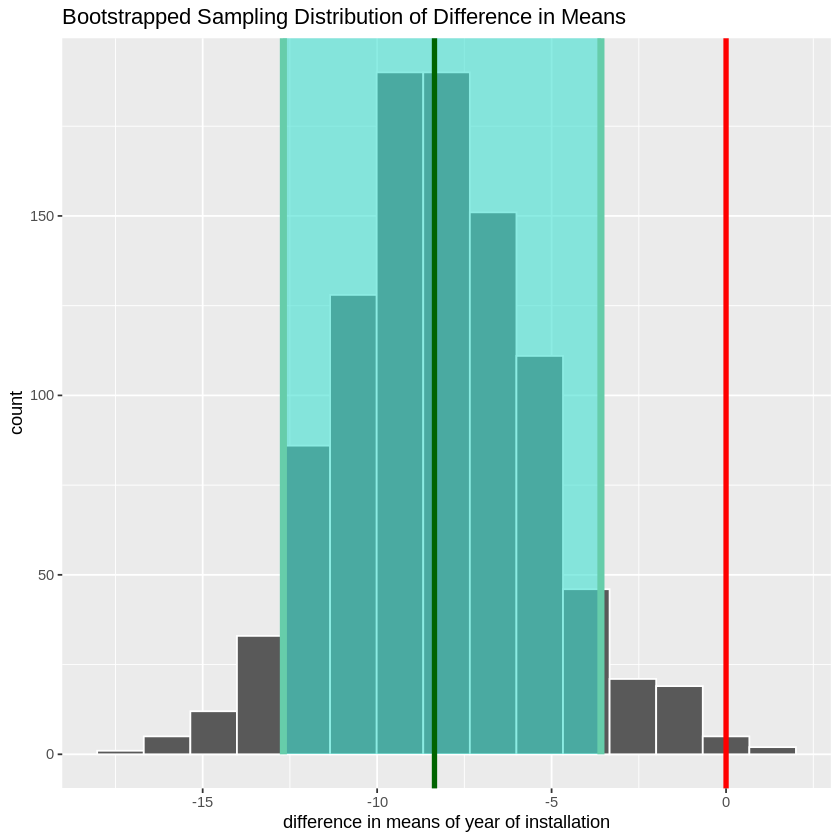

In [71]:
visualize(pop_bootstrap_distribution) + 
    shade_confidence_interval(endpoints = pop_percentile_ci) +
    geom_vline(xintercept = pull(pop_obs_diff_means), col = "dark green", size = 1.5) + # alternative hypothesis
    geom_vline(xintercept = 0, col = "red", size = 1.5) + # null hypothesis
    ggtitle("Bootstrapped Sampling Distribution of Difference in Means") +
    xlab("difference in means of year of installation")

<span style="color:gray">Figure 4: Bootstrapped sampling distribution of difference in means</span>

### Using CLT

Although both methods above resulted in us successfully rejecting the null hypothesis, we wanted to compare our results to an asymptotic method. To do so, we apply the CLT by assuming the following:

- The population distribution is normally distributed.
- The data was sampled randomly and independently.
- The population isn't overly dependent on our sample; the population is at least ten times of our sample size of `n = 257`.

Even though our data is not normally distributed, as is visible in the preliminary histograms above, we can use CLT to hypothesis test. According to the theorem, the distribution of sample means for any population with mean $\mu$ and standard deviation $\sigma$ will be approximately normal as long as the sample is representative and large enough. Since we don't know the population standard deviation, we conduct an unpaired, two-sample t-test using the sample standard deviation instead.

The test statistic for a two-sample t-test regarding difference in means is

$$T = {\dfrac{\bar{x} - \bar{y}}{\sqrt{\dfrac{{s_{1}}^2}{n_{1}}+\dfrac{{s_{2}}^2}{n_{2}}}}}$$

**Test Statistic**

To calculate the test statistic, we need the means, sizes, and variances for the two sample groups. We already parsed these values in Table 2 of the Preliminary Data Exploration.

By inspection, a test statistic as large as -2.99 will likely result in a rejected null hypothesis but to be sure, we need to follow through with the hypothesis test. Since we're conducting a t-test, we need to know the degrees of freedom before determining the p-value at a 0.10 significance.

In [75]:
art_test_stat <- (mean_dt - mean_mp) / 
                sqrt(var_dt/n_dt + var_mp/n_mp)
art_test_stat

[1] -2.987676

**Degrees of Freedom**

Now, if $H_0$ is true, i.e., if $\mu_{\text{Downtown}} = \mu_{\text{Mount Pleasant}}$, the $T$ statistic from the previous exercise follows a $t$ distribution with approximately

$$
\nu = \frac{
    \left(\frac{s_{Downtown}^2}{n_1}+\frac{s_{Mount Pleasant}^2}{n_2}\right)^2
}
{
\frac{s_{Downtown}^4}{n_1^2(n_1-1)}+\frac{s_{Mount Pleasant}^4}{n_2^2(n_2-1)}
}
$$
degrees of freedom.

In [76]:
art_df <- (var_dt/n_dt + var_mp/n_mp)^2 / (
    (var_dt/n_dt)^2/(n_dt - 1) + 
    (var_mp/n_mp)^2/(n_mp - 1))

art_df

[1] 109.7728

**P-Value**

At a 0.10 significance level, we reject our null hypothesis, as `p-value` $= 0.003$ <<< $\alpha = 0.10$. This means that there is a statistically significant difference between the mean year of installation between the two neighbourhoods.

In [77]:
art_clt_p_value <-  2 * pt(abs(art_test_stat),
                      df = art_df,
                      lower.tail = FALSE)

art_clt_p_value

[1] 0.003468358

**Confidence Intervals**

Simply reporting the p-value is not enough to determine the relationship that the two means have to one another. As such, it's best practice to report confidence intervals as well.

The 90% CI of [-13.00, -3.72] means that we're 90% confident that the true population parameter of the difference in mean year of installation is between -13.00 and -3.72 years. The 95% CI of [-13.90, -2.81] suggests we're more confident that it falls within this wider range. Either way, this further supports our decision to reject the null hypothesis (0 does not occur in this range).

In [78]:
# 90% confidence interval
art_clt_ci_0.90 <- tibble(lower_ci_0.9 = (mean_dt - mean_mp) + qt(0.05, art_df) * sqrt(var_dt/n_dt + var_mp/n_mp),
                          upper_ci_0.9 = (mean_dt - mean_mp) + qt(0.95, art_df) * sqrt(var_dt/n_dt + var_mp/n_mp)
                        )

# 95% confidence interval
art_clt_ci_0.95 <- tibble(lower_ci_0.95 = (mean_dt - mean_mp) + qt(0.025, art_df) * sqrt(var_dt/n_dt + var_mp/n_mp),
                          upper_ci_0.95 = (mean_dt - mean_mp) + qt(0.975, art_df) * sqrt(var_dt/n_dt + var_mp/n_mp)
                        )

art_clt_ci_0.90
art_clt_ci_0.95

lower_ci_0.9,upper_ci_0.9
<dbl>,<dbl>
-12.99619,-3.716674


lower_ci_0.95,upper_ci_0.95
<dbl>,<dbl>
-13.89949,-2.813372


**Using R's Automatically Calculated T-Test**

To ensure that all of our calculations using asymptotics are correct, we use the `t.test` function to carry out the hypothesis test.

As you can see in the `art_t_test` tibble, the `estimate` of -8.356432 corresponds to `obs_mean_year_diff` we computed earlier, `estimate1` correponds to the mean year of installation for Downtown (`mean_dt`) and `estimate2` correponds to the mean year of installation for Downtown (`mean_mp`).

Furthermore, the `statistic` of -2.987676 correponds to `art_test_stat`, the `p.value` of 0.003 corresponds with `art_clt_p_value`, and the `parameter` of 109.8 corresponds with `art_df`. The `conf.low` and `conf.high` represent the values we calculated for the 95% CI in `art_clt_ci_0.95`.

In [80]:
# splitting it into two groups for two sample t-test
dt <- filter(art_data_required, Neighbourhood == 'Downtown')
mp <- filter(art_data_required, Neighbourhood == 'Mount Pleasant')

# carrying out the t-test
art_t_test <- tidy(
    t.test(x = dt$YearOfInstallation,
           y = mp$YearOfInstallation,
           alternative = "two.sided")
    )

art_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-8.356432,2000.572,2008.929,-2.987676,0.003468358,109.7728,-13.89949,-2.813372,Welch Two Sample t-test,two.sided


<span style="color:gray">Table 4: R's `t.test` results</span>

**Comparing Bootstrapping to Asymptotics**

<mark> TODO: <mark>
Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.

## Discussion 🏙🌆🌉🌃

We lastly interpret the results we obtained in the previous section with respect to the main question of our project.

<mark> TODO <mark>
    
**What did we find?** Based on the various methods we hypothesis-tested, we safely rejected the null hypothesis at the 10% significance level because there was a statistically significant difference between the mean installations years of public art in the two Vancouver regions. This is contrary to what we expected to find; in our project proposal we said that "Based on preliminary results, we expect to fail to reject the null hypothesis at the 10% significance level because there appears to be no large difference between the mean installations years of public art in the two Vancouver regions."

**Impact of findings?** The confidence intervals for each group would show the uncertainty we have around our estimates, and could provide a simple measurement of the volume of artistic work being put out over the years, which might be indicative of the speed of urbanization and how it affects different parts of a major city.

**Future questions?**  We could examine the volume of public art in Vancouver according to a different categorical variable, such as the artist's cultural background (e.g. Indigenous). We could study art in other big cities, or examine whether the location or volume of public art correlates with the city's level of development.

## References

Arts, Culture, and Community Services - Cultural Services. “Public Art.” (2022). Retrieved November 6, 2022, from https://opendata.vancouver.ca/explore/dataset/public-art/information/?location=12,49.25257,-123.13133.

A mini-guide to Vancouver's public art. Vancouver. (n.d.). Retrieved November 6, 2022, from https://www.destinationvancouver.com/activities/sightseeing/public-art-mini-guide/ 

Szőke, T., &amp; Parizeau, K. (2018). Community-based public art and gentrification in the Downtown Eastside of Vancouver. GeoHumanities, 5(1), 157–177. https://doi.org/10.1080/2373566x.2018.1543554 
https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj69K7_zZr7AhWzAjQIHdxLDqYQFnoECBoQAw&url=https%3A%2F%2Fwww.destinationvancouver.com%2Factivities%2Fsightseeing%2Fpublic-art-mini-guide%2F&usg=AOvVaw1C7YOKtvv8kVHkkdl_XYie